In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from pathlib import Path

from fastai.tabular.all import *
from fastai.basics import *
from fast_tabnet.core import *


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.seasonal import seasonal_decompose


warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

PATH = Path("D:/data/demand_optimization")
MPATH = Path("D:/models/demand_optimization")

# Demand forecasting demo

This notebook isn't a tutorial, so I won't be explaining a lot of the stuff and will focus purely on reporting findings. I'm assuming that if you're reading this you either a) know how to code and want to see how I work or b) are interested in seeing how AI tech can solve your business challenges.

Also, there's a lot of bad coding here, such as  calculating variables in the global namescope or recalculating the same intermediates multiple times. This is really just to lean into the Notebook format so people can copy-paste as needed. Obviously production code will live in `.py` files and will handle compute and memory in a more efficient way.

## Find some numbers to experiment with

So to begin with, we need some data. I grabbed [a random store demand dataset off Kaggle](https://www.kaggle.com/c/demand-forecasting-kernels-only/) in order to demonstrate how to do the technology side here. I was led to this dataset by [the following blog post](https://towardsdatascience.com/machine-learning-for-store-demand-forecasting-and-inventory-optimization-part-1-xgboost-vs-9952d8303b48), which contains a number of minor methodological errors that we'll analyse in a later section. We'll definitely build on that approach though, test XGB for a semi-replication then move to deep learning to squeeze out a little more performance via the Rossmann method.

## Check what we have

Standard exploratory data analysis, we're going to start by reading in both the train and test sets, and work through figuring out the data. We know from Kaggle we have number of sales across 10 stores and 50 products.

In [2]:
train = pd.read_csv(PATH/"train.csv", parse_dates=["date"])
print(train.head())
print(train.describe())

        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
               store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000


In [3]:
test = pd.read_csv(PATH/'test.csv').drop(["id"], axis=1)
print(test.head())

         date  store  item
0  2018-01-01      1     1
1  2018-01-02      1     1
2  2018-01-03      1     1
3  2018-01-04      1     1
4  2018-01-05      1     1


Right, so sales is obviously our target, and the value we'll need to be careful about. They also seem fairly long-tailed in the positive direction, which is to be expected. Given it's not in the test set, we can't use this value directly to estimate projected demand, but we may be able to use aggregates (as per the blog post - average monthly sales etc) to estimate our central tendency. We'll address this in a moment.

First, we know the data is fairly skewed...let's see how badly skewed, because log transforms will likely fix it.

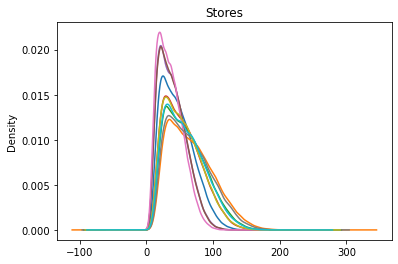

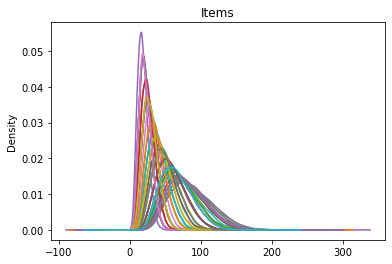

In [4]:
train.sales.groupby(train.store).plot.kde(title="Stores")
plt.show()

train.sales.groupby(train.item).plot.kde(title="Items")
plt.show()

Order of magnitude differences in the items, but within +/- 200% in the stores. We're going to use a quick log transform to try symmetrise these numbers, curbing the long tail behavior. Whether or not this is desirable in practice depends on the tradeoffs the business is willing to accept.

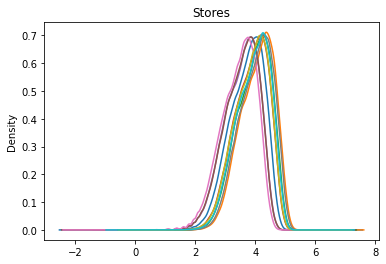

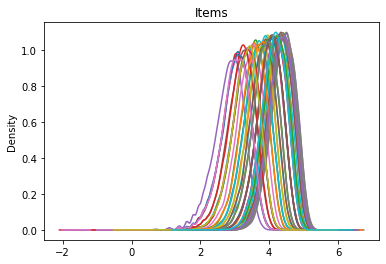

In [5]:
train.sales.replace({0:1}).apply(np.log).groupby(train.store).plot.kde(title="Stores")
plt.show()

train.sales.replace({0:1}).apply(np.log).groupby(train.item).plot.kde(title="Items")
plt.show()

This is looking better, at least as a starting point. We know that if symmetry is causing problems later, that we can use logs to correct some of the biases.

This dataset can largely be considered a "tall" dataset under Hadley Wickham's framework. It's tempting to just consider each product as a univariate time series, but this ignores the possibility that there may be correlations between products. It stands to reason all products will be highly correlated, as busy days will see higher sales in all products, but we may be able to find some structure that can be exploited.

In [6]:
data = train.copy()
data['item'] = data['item'].apply(lambda x: f"item_{x}")
data = pd.pivot_table(data, index=["date", "store"], columns=['item']).sort_index().reset_index(level=1)
data.head()

store  sales                                                  \
item             item_1 item_10 item_11 item_12 item_13 item_14 item_15   
date                                                                      
2013-01-01     1     13      37      37      33      37      22      42   
2013-01-01     2     12      51      51      55      51      33      65   
2013-01-01     3     19      38      37      38      49      37      61   
2013-01-01     4     10      30      47      36      46      43      46   
2013-01-01     5     11      31      26      22      33      22      31   

                            ...                                         \
item       item_16 item_17  ... item_46 item_47 item_48 item_49 item_5   
date                        ...                                          
2013-01-01      14      13  ...      30      17      21      18     11   
2013-01-01      15      24  ...      43      12      45      29      4   
2013-01-01      15      26  ...      33      10      28      21     13   
2013-01-01      13      20  ...      38      23      34      12     10   
2013-01-01      10       9  ...      20       9      21       9      9   

                                                
item       item_50 item_6 item_7 item_8 item_9  
date                                            
2013-01-01      30     31     25     33     18  
2013-01-01      43     34     39     49     28  
2013-01-01      45     34     40     54     28  
2013-01-01      38     24     26     34     19  
2013-01-01      19     20     21     30     21  

[5 rows x 51 columns]

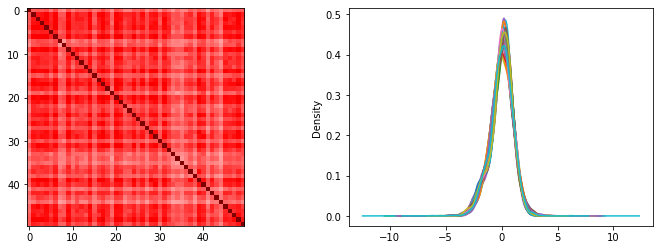

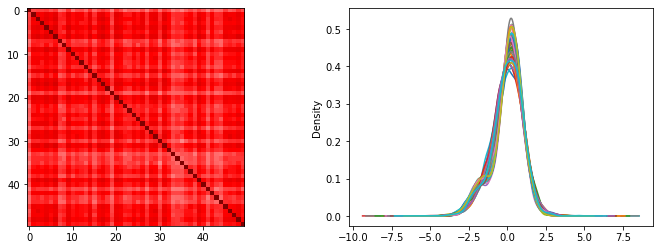

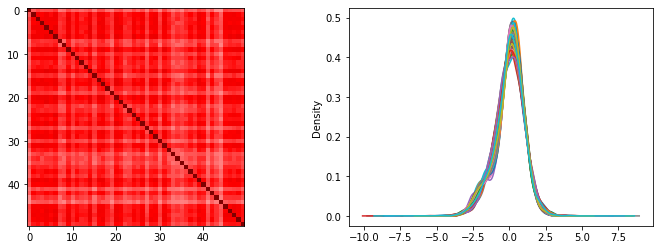

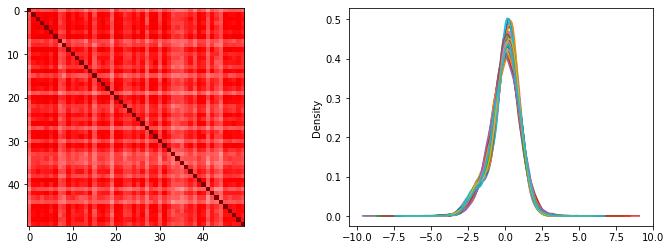

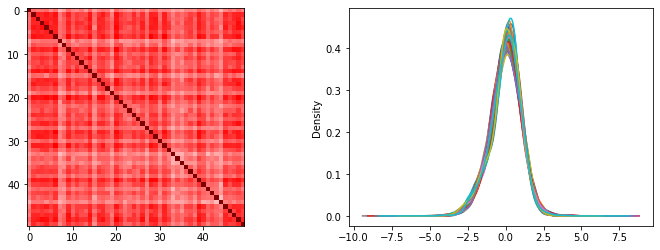

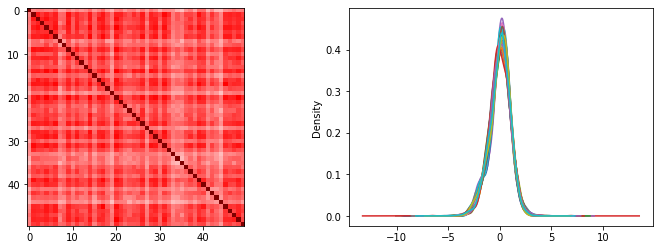

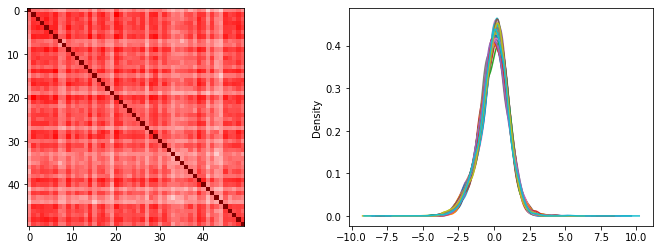

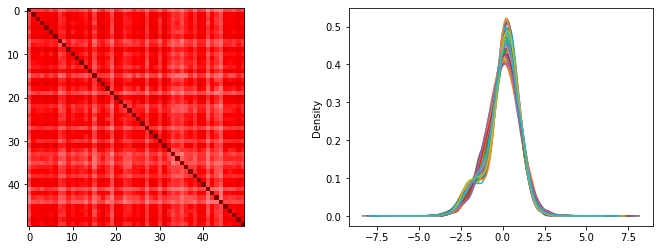

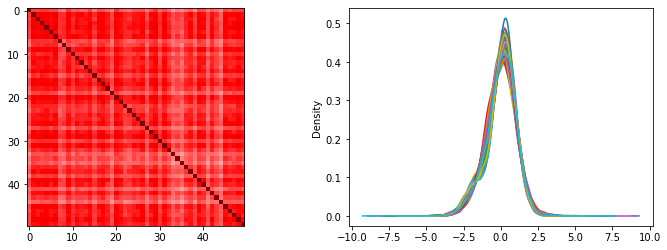

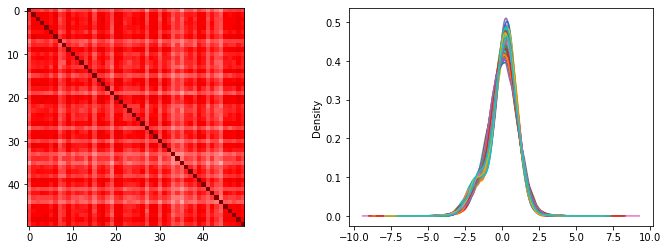

In [7]:
for value in data.store.unique():
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    temp = data[data.store==value].drop(['store'], axis=1)
    temp = temp.apply(np.log1p).diff()
    temp = temp.div(temp.std())
    
    ## Red is towards +1
    ax[0].imshow(temp.corr(), vmin=-1, vmax=1, cmap='seismic')
    temp.plot.kde(ax=ax[1], legend=False)
    plt.show()

Looking at this, the large amount of correlation is mildly concerning, but it may not be as drastic a problem as I suspect. If we use entity embeddings, then this may actually prove useful.

## Sales Growth and Time Series Modelling

Let's discuss one of the methodological issues with the blog post I ID'd. The author basically allowed all kinds of data leakage from past to future. In time series, using a fully random training set is bad practice, because you can (in effect) allow "tomorrow" and "yesterday" to predict "today". When doing time series analysis, all holdout sets should be done as a forecast from a point in time. By falsely assuming timelessness, you end up with a wildly inflated idea of how your model will actually perform. This is doubly true for tree-based models like XGBoost, which have difficulties when projecting beyond the domain of the data. In other words, if the range of the function has a growth pattern, the best XGB can do is project the maximum value in the training set.

This error showed up in a few ways. The first is how the author anchored sales values to years. This was done in two ways. The first was including the year as a feature - not necessarily a terrible idea, but very coarse compared to e.g. a continuous representation of time. In a tree-based model, including the year as an integer will essentially index to an entire year. Given that you're generally interested in predicting the future, though, this will lock all values to the last observed year.

The second issue was the matter of including an "average sale" of products. Basically, the author calculated the average sale of each product per store and included it. Overlooking the identified issue about using the future to predict the past, there's another issue here that will hurt accuracy. That is, the further you project this model forward (e.g. the entirety of 2018) the less useful that baseline will be. Coupled with the inability of tree based models to extrapolate and there's a recipe for trouble.

Below I'm plotting the mean and standard deviation of the values over time.

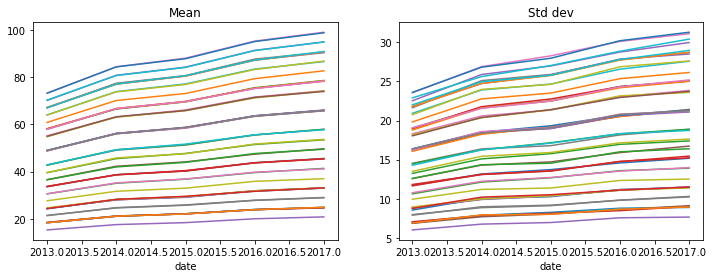

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
temp = data.drop(["store"], axis=1)
temp.groupby(temp.index.year).mean().plot(title= "Mean", legend=False, ax=ax[0])
temp.groupby(temp.index.year).std().plot(title="Std dev", legend=False, ax=ax[1])
plt.show()

As expected, every item sees a growth trend. Annoyingly, the standard deviation is also growing over time, and this is because the difference between store growth rates is diverging. This means that if we want to include average sales growth projections we'll need to do it on a per-store basis.

To solve this issue, there are a few approaches that one can take. If you're using regression-based models e.g. neural nets, you can encode the year variable (or any other variable, for that matter!) as a float of the form 2017.66, with the decimal reflecting progress through the year. However, tree based models will still fail to work with this. Instead, I'm going to work with the idea of simple projections. Looking at the above charts we can see that all the growth rates are more or less linear (+/- some variation, with saturation at the top). As such, we'll subtract out seasonal effects then see what trend remains. We'll then build a quick quadratic regression to extend the smooth curve into the future. The decomposition can then be added into the machine learning model for better accuracy.

I'm not going to be super rigorous here about avoiding data leaks, because that's more an issue for production. I'm just generally going to apply good practice and move forward to show the general idea. In general I'd be looking to use something with multiple seasonal components such as Facebook's Prophet to really isolate the main trend, or do proper statistical work with multilevel modelling and perhaps Gaussian processes a la the Gelman births model. If I return to this issue, I may experiment with some other techniques to combine the benefits of continuous variables and the expressivity of discrete ones, such as linear interpolations of embeddings to capture the smooth progression of time. For now, I'm going to keep things basic.

Let's begin with the time series decomp, just looking at one example at first.

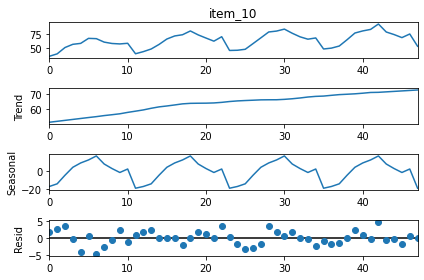

Stddev of mean to compare with additive residual size:  13.277878198325757


In [9]:
def decompose(ts_df, remove_index=False):     
    # This is inefficient but its fast enough on this dataset
    # that we don't need to worry
    yearmonth = ts_df.index.year.astype(str) + "-" + ts_df.index.month.astype(str).str.zfill(2)
    result = seasonal_decompose(
        ts_df.groupby(yearmonth).mean().reset_index(drop=True) if remove_index \
            else ts_df.groupby(yearmonth).mean(),
        period=12, model="additive", extrapolate_trend=3)
    return yearmonth, result


# Show the series
df = data.copy()
cols = df.columns.droplevel().tolist()
cols[0] = "store"
df.columns = cols
df.columns.name = None

ts = df.loc[df['store']==1, "item_10"]
ts = ts[ts.index < "2017-01-01"]
yearmonth, result_a = decompose(ts, True)
result_a.plot()
plt.show()

print("Stddev of mean to compare with additive residual size: ", ts.groupby(yearmonth).mean().std())


There's a lot that could be tuned here, but this is good enough for a proof of concept. We're going to recycle the seasonal components and fit a simple model to the trend, and this will give us our model. We're now going to build the trend and seasonal component for every shop/item pair.

In [10]:
def convert_to_lintime(point):
    start_date = pd.Timestamp('2013-01-01')
    return (point-start_date).days

def mid_offset(point):
    return point.days_in_month/2 +0.5

def gen_seasonal(result):
    # Returns lookup function for seasonal component
    seasonal = result.seasonal.copy().dropna()
    seasonal.index = seasonal.index.str.split('-').str[1].astype(int)
    d = seasonal.drop_duplicates().to_dict()
    return lambda x: d[x]

def gen_trend(result, ts_df, yearmonth):
    trend = result.trend.copy().dropna()
    
    tl = yearmonth.to_series()
    tl.index= ts_df.index
    tl = tl.drop_duplicates()
    
    x = np.array([convert_to_lintime(i) + mid_offset(i) for i in tl.index])
    model = make_pipeline(PolynomialFeatures(2), LinearRegression())
    model.fit(x.reshape([-1,1]), trend)
    return lambda x: model.predict([[x]])[0]


ts = df[df.index < "2017-01-01"].copy()

trend_data = defaultdict(dict)
for store in range(1, 11):
    for i in range(1, 51):
        
        lookup = f"{store}-{i}"
        temp = ts.loc[ts['store']==store, f"item_{i}"]
        yearmonth, result = decompose(temp)
        trend_data[lookup]['month'] = gen_seasonal(result)
        trend_data[lookup]['trend'] = gen_trend(result, temp, yearmonth)


We'll also briefly do the same to extract the trend for the day of the week...except because the long term trend will be so noisy, we will throw it away. The logic behind this is if we can account for all these linear trends, then it makes the model's job a lot easier in the end.

In [11]:
def decompose_week(trend_data, store, item, ts_df, remove_index=False):     
    # This is inefficient but its fast enough on this dataset
    # that we don't need to worry
    lookup = f"{store}-{item}"
    temp = ts_df.copy()
    temp -= ts_df.index.month.to_series().apply(lambda x: trend_data[lookup]['month'](x)).values
    temp -= ts_df.index.to_series().apply(lambda x: trend_data[lookup]['trend'](convert_to_lintime(x))).values
    result = seasonal_decompose(
        temp.reset_index(drop=True) if remove_index \
            else temp,
        period=7, model="additive", extrapolate_trend=0)
    return result

def decompose_days(trend_data, store, item, ts_df, remove_index=False):     
    # This is inefficient but its fast enough on this dataset
    # that we don't need to worry
    lookup = f"{store}-{item}"
    temp = ts_df.copy()
    

    # Way too explicit here because I was too lazy to do negation properly!
    idx = temp.index.month == 2
    idx[idx] = temp[idx].index.day == 29
    temp = temp[~idx]

    temp -= temp.index.month.to_series().apply(lambda x: trend_data[lookup]['month'](x)).values
    temp -= temp.index.to_series().apply(lambda x: trend_data[lookup]['trend'](convert_to_lintime(x))).values
    temp -= temp.index.to_series().apply(lambda x: trend_data[lookup]['week'](x.dayofweek)).values
    result = seasonal_decompose(
        temp.reset_index(drop=True) if remove_index \
            else temp,
        period=365, model="additive", extrapolate_trend=7)
    return  result, idx

def get_weekday(result, temp):
    d = result.seasonal.copy().groupby(temp.index.dayofweek).mean().to_dict()
    return lambda x: d[x]

def get_yearday(result, temp, idx):
    temp = temp[~idx].copy()
    d = result.seasonal.copy()[~temp.index.is_leap_year].groupby(
        temp[~temp.index.is_leap_year].index.dayofyear).mean().to_dict()
    return lambda x: d[x]

ts = df[df.index < "2017-01-01"].copy()

for store in range(1, 11):
    for i in range(1, 51):
        lookup = f"{store}-{i}"
        temp = ts.loc[ts['store']==store, f"item_{i}"]
        result1 = decompose_week(trend_data, store, i, temp.copy())
        trend_data[lookup]['week'] = get_weekday(result1, temp)
        
        result2, idx = decompose_days(trend_data, store, i, temp.copy())
        trend_data[lookup]['dayofyear'] = get_yearday(result2, temp, idx)
        

Finally we're going to do a quick simulation into 2017, to see how our values project forwards.

In [12]:
def gen_month_offset(trend_data, dt_idx, si_lookup):
    if type(si_lookup)==str:
        return dt_idx.month.to_series().apply(lambda x: trend_data[si_lookup]['month'](x)).values
    else:
        data = [trend_data[lu]['month'](x) for lu, x in zip(si_lookup, dt_idx.month.values)]
        return np.array(data)
        
def gen_trend_offset(trend_data, dt_idx, si_lookup):
    if type(si_lookup)==str:
        return dt_idx.to_series().apply(lambda x: trend_data[si_lookup]['trend'](convert_to_lintime(x))).values
    else:
        data = [trend_data[lu]['trend'](convert_to_lintime(x)) for lu, x in zip(si_lookup, dt_idx.values)]
        return np.array(data)

def gen_week_offset(trend_data, dt_idx, si_lookup):
    if type(si_lookup)==str:
        return dt_idx.to_series().apply(lambda x: trend_data[si_lookup]['week'](x.dayofweek)).values
    else:
        data = [trend_data[lu]['week'](x) for lu, x in zip(si_lookup, dt_idx.dayofweek.values)]
        return np.array(data)

def gen_dayofyear_offset(trend_data, dt_idx, si_lookup):
    doy = pd.Series(dt_idx.dayofyear.values, index=dt_idx)
    doy[dt_idx.is_leap_year & (doy > 59)] -= 1
    if type(si_lookup)==str:
        return doy.apply(lambda x: trend_data[si_lookup]['dayofyear'](x)).values
    else:
        data = [trend_data[lu]['dayofyear'](x) for lu, x in zip(si_lookup, doy)]
        return np.array(data)

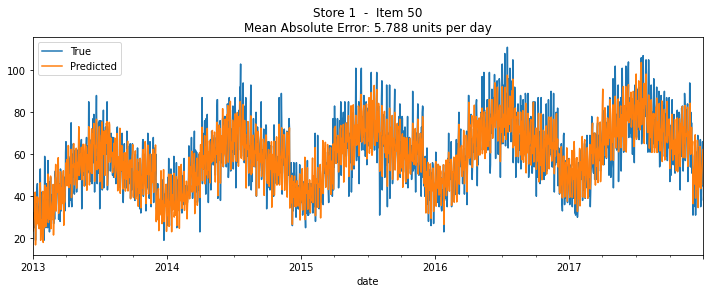

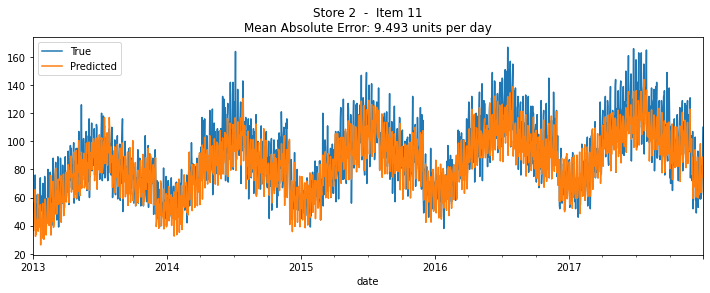

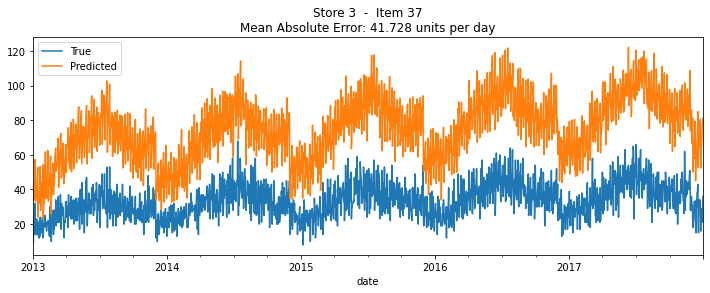

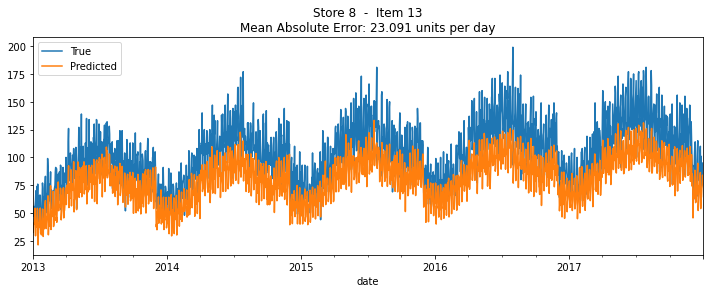

Overall MAE: 22.26743664052901
Overall PMAE: 66.1500790587981


In [25]:
for store, item in [(1, 50), (2,11), (3,37), (8, 13)]:
    lookup = f"{store}-{i}"
    y_true = df.loc[df['store']==store, f"item_{item}"]
    y_pred = pd.Series(gen_month_offset(trend_data, y_true.index, lookup), index=y_true.index)
    y_pred += gen_trend_offset(trend_data, y_pred.index, lookup)
    y_pred += gen_week_offset(trend_data, y_pred.index, lookup)
    y_pred += gen_dayofyear_offset(trend_data, y_pred.index, lookup)

    error = (y_true - y_pred).abs().mean()
    plt.figure(figsize=(12,4))
    plt.title(f"Store {store}  -  Item {item}\nMean Absolute Error: {error:.3f} units per day")
    y_true.plot(label="True")
    y_pred.plot(label="Predicted")
    plt.legend()
    plt.show()

errors = []
errors_pct = []
for store in range(1, 11):
    for item in range(1, 51):
        lookup = f"{store}-{i}"
        y_true = df.loc[df['store']==store, f"item_{item}"]
        y_pred = pd.Series(gen_month_offset(trend_data, y_true.index, lookup), index=y_true.index)
        y_pred += gen_trend_offset(trend_data, y_pred.index, lookup)
        y_pred += gen_week_offset(trend_data, y_pred.index, lookup)
        y_pred += gen_dayofyear_offset(trend_data, y_pred.index, lookup)
        error = (y_true - y_pred).abs().mean()
        errors.append(error)
        errors_pct.append(error/y_true.mean())

errors = pd.Series(errors).mean()
errors_pct = pd.Series(errors_pct).mean() * 100
print(f"Overall MAE: {errors}")
print(f"Overall PMAE: {errors_pct}")

PMAE here is the mean absolute error, divided by the overall mean of the test series (i.e. 2017). This is to account for the different raw scales we observed during our EDA.

As can be seen, this isn't too bad. Some series are captured VERY well, others, not so well. For a very simple, crude hack...which definitely has room for improvement via state space models or some kind of joint/simultaneous decomposiiton...this is a good place to start. Time to move to the more advanced models to see if we can improve on this error somewhat.

## From Stats to AI

At this point, we're ready to do some machine learning. First, we're going to try the simple way, with a basic XGB, using our original data structure in train (defined up top), and some breakouts of the time features. Again, this will loosely be replicating the methods of the blog post, but with our interpolated sales projections. We're going to drop `week_of_year` because this value doesn't actually help us much - `day_of_year` already covers it.

We're also going to add in our periodic decompositions. As these are all essentially linear, this will allow our model to focus on solving the nonlinear parts of the equation.

In [69]:
# Dataset generation

def gen_date_feats(df):
    df["month"] = df.index.month
    df['day'] = df.index.day
    df['day_prop'] = df.index.day / df.index.daysinmonth
    df["day_of_week"] = df.index.day_of_week
    df['day_of_year'] = df.index.day_of_year
    df["year_prop"] = df.index.day_of_year
    df.loc[df.index.is_leap_year, "year_prop"] /= 366
    df.loc[~df.index.is_leap_year, "year_prop"] /= 365
    df.loc[(df.index.is_leap_year) & (df.day_of_year > 59), "day_of_year"] =- 1
    return df

X = train.set_index('date').drop(["sales"], axis=1).copy()
X = gen_date_feats(X)
X['si_lookup'] = X.store.astype(str) + "-" + X.item.astype(str)
 ## Trend is super slow due to it handling values one at a time
X['trend'] = gen_trend_offset(trend_data, X.index, X.si_lookup)
X['month_os'] = gen_month_offset(trend_data, X.index, X.si_lookup)
X['week_os'] = gen_week_offset(trend_data, X.index, X.si_lookup)
X['doy_os'] = gen_dayofyear_offset(trend_data, X.index, X.si_lookup)

drop_cols = ['si_lookup']
X.drop(drop_cols, axis=1,inplace=True)
y = train.set_index('date')['sales'].copy()
X_train, X_test = X.loc[:"2016-12-31"], X.loc["2017-01-01":]
y_train, y_test = y.loc[:"2016-12-31"], y.loc["2017-01-01":]

We're going to train with squared error here to get an idea of how results will improve, but log error would be better if we think low-volume items are more valuable. That would require price info that we don't have.

In [ ]:
import xgboost as xgb

# XGB imported here due to conflicts in C compilers

dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

model = xgb.train(params={'objective':'reg:squarederror','eval_metric':'mae'}
                ,dtrain = dtrain, num_boost_round = 500,
                early_stopping_rounds = 20, evals = [(dtest,'test')],
                )

y_pred = pd.Series(model.predict(dtest), index=y_test.index)

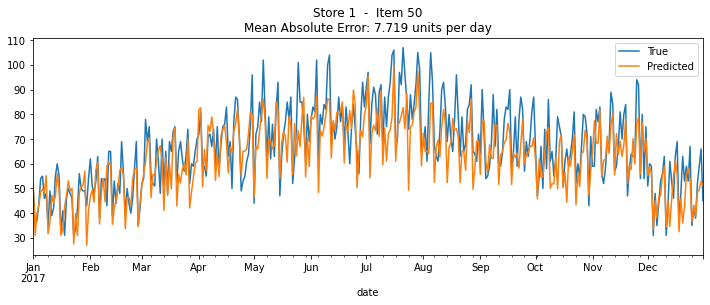

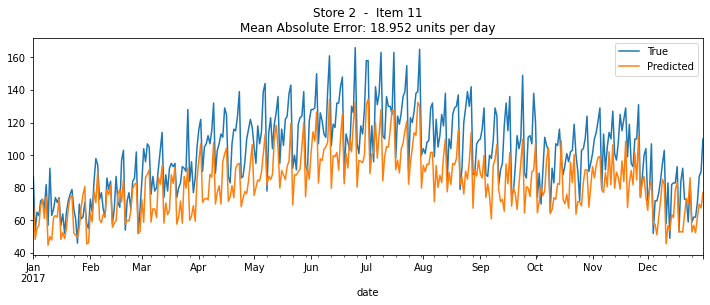

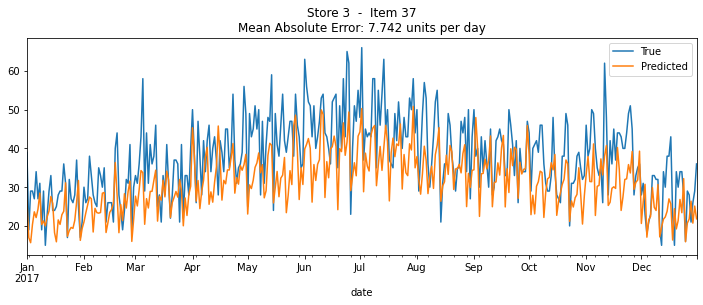

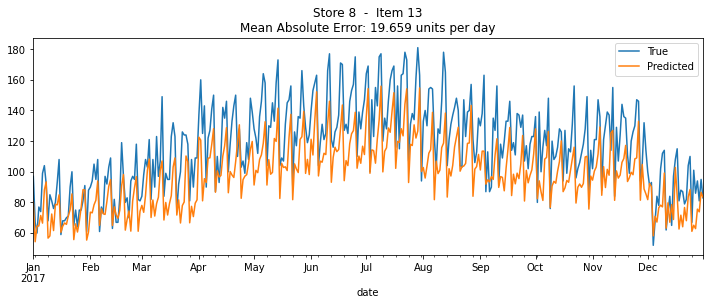

Overall MAE: 10.518869400024414
Overall PMAE: 0.18337287673690783


In [712]:
for store, item in [(1, 50), (2,11), (3,37), (8, 13)]:
    idx = (X_test['store'] == store) & (X_test['item']==item)

    error = (y_test[idx] - y_pred[idx]).abs().mean()
    plt.figure(figsize=(12,4))
    plt.title(f"Store {store}  -  Item {item}\nMean Absolute Error: {error:.3f} units per day")
    y_test[idx].plot(label="True")
    y_pred[idx].plot(label="Predicted")
    plt.legend()
    plt.show()

errors = (y_test-y_pred).abs().mean()
errors_pct = []
for store in range(1, 11):
    for item in range(1, 51):
        idx = (X_test['store'] == store) & (X_test['item']==item)
        errors_pct.append(((y_test[idx] - y_pred[idx]).abs()/y_test[idx]).mean())
        
errors_pct = pd.Series(errors_pct).mean()

print(f"Overall MAE: {errors}")
print(f"Overall PMAE: {errors_pct}")

Editing note: Please note that PMAE here is calculated as a proportion rather than a percentage - I find proportions more natural to think about and so I didn't notice I'd stopped multiplying by 100. This is an error on my part, but it doesn't affect the interpretation.

Right, so an excellent improvement. We've halved absolute error, and cut our estimation error on individual products to less than 20%. While far from ideal, this is a big step forward. Best part is this is accurate projections a whole year ahead of target.

While we could tune the XGB for better results (I think maybe getting as low as 16% error), I'm fairly sure the big gains will be made using deep learning. The XGB model has worked remarkably well despite the lack of log transform, although this is kind of to be expected. My suspicion is that we'll need to turn to it for deep learning (as deep learning is fundamentally more about spaces, rather than sections) but again, we can worry about this in the next step.

In [158]:
model_data = pd.concat([X, y], axis=1).sort_index()
procs = [Categorify, FillMissing, Normalize]
cat_names = ['store', 'item', 'month', 'day', 'day_of_week', 'day_of_year']
cont_names = ['day_prop', 'year_prop', 'trend', 'month_os', 'week_os', 'doy_os']

dls = TabularDataLoaders.from_df(
    model_data, path=MPATH,
    cat_names = cat_names, cont_names=cont_names,
    y_names="sales",
    procs=procs,
    valid_idx=list(range(len(X_train),len(X))),
    bs=4096, 
)

tab_config = tabular_config(ps=0.5, act_cls=Mish())

learn = tabular_learner(dls,loss_func=mae,
                        config= tab_config,
                        metrics=[mae, rmse, msle, R2Score()],
                        opt_func=ranger, wd=0.05)

In [159]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,mae,_rmse,msle,r2_score,time
0,8.095880,6.895808,6.895808,8.959030,0.030785,0.919378,00:03
1,6.656913,7.125717,7.125717,9.243829,0.032749,0.914171,00:03
2,6.484752,6.798677,6.798677,8.875767,0.029261,0.920870,00:03
3,6.342154,6.887291,6.887291,8.941833,0.029977,0.919688,00:03
4,6.219697,6.810275,6.810275,8.904379,0.029115,0.920359,00:03
5,6.083888,6.788793,6.788793,8.864777,0.028971,0.921066,00:03
6,6.003048,6.993546,6.993546,9.214669,0.029746,0.914712,00:03
7,5.919433,6.778125,6.778125,8.827480,0.029010,0.921729,00:03
8,5.828273,6.757906,6.757906,8.817924,0.028770,0.921898,00:03
9,5.751812,6.760043,6.760043,8.821767,0.028756,0.921830,00:03


In [187]:
dl = learn.dls.test_dl(X_test)
y_pred = pd.Series(learn.get_preds(dl=dl)[0].numpy().flatten(),
                   index=y_test.index)

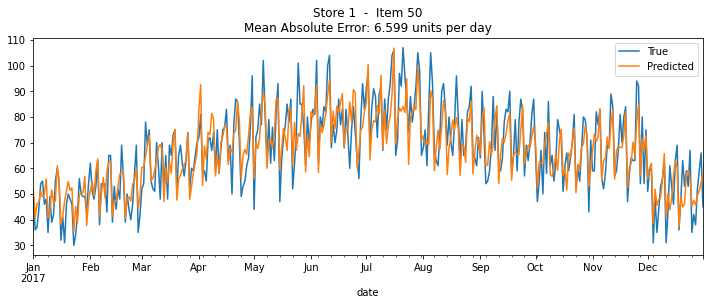

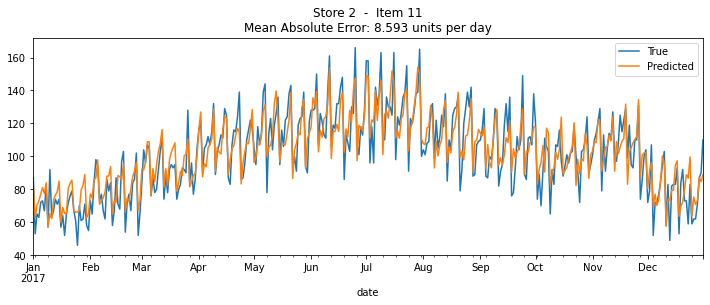

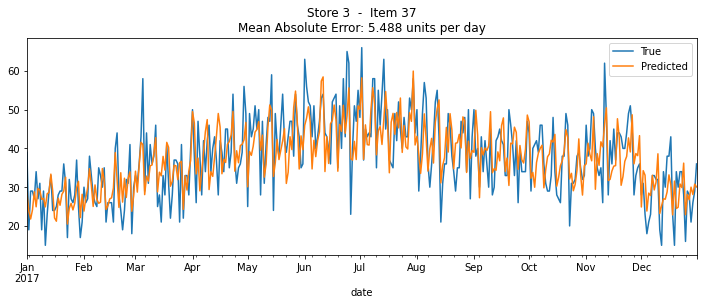

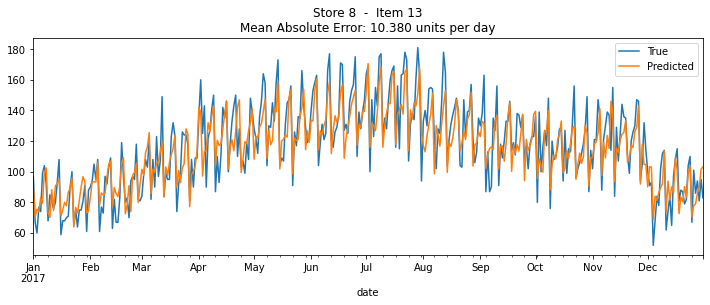

Overall MAE: 6.760041036193011
Overall PMAE: 0.13711631507970082


In [188]:
for store, item in [(1, 50), (2,11), (3,37), (8, 13)]:
    idx = (X_test['store'] == store) & (X_test['item']==item)

    error = (y_test[idx] - y_pred[idx]).abs().mean()
    plt.figure(figsize=(12,4))
    plt.title(f"Store {store}  -  Item {item}\nMean Absolute Error: {error:.3f} units per day")
    y_test[idx].plot(label="True")
    y_pred[idx].plot(label="Predicted")
    plt.legend()
    plt.show()

errors = (y_test-y_pred).abs().mean()
errors_pct = []
for store in range(1, 11):
    for item in range(1, 51):
        idx = (X_test['store'] == store) & (X_test['item']==item)
        errors_pct.append(((y_test[idx] - y_pred[idx]).abs()/y_test[idx]).mean())
        
errors_pct = pd.Series(errors_pct).mean()

print(f"Overall MAE: {errors}")
print(f"Overall PMAE: {errors_pct}")

Right, so we're down to within 14% error per day, and this is on our first attempt. It's a fairly certain bet that we can do better than this. Given that it's performing fairly well, we may not need the log transform we explored above. Looking at the data, we're missing a lot of the random spikes but this is to be expected - we're only able to predict signal, and in something inherently noisy like a sales figure, we'll always have a threshold we can't necessarily get below. In aggregate, we're likely under-predicting the spikes (in both directions) but getting very close to the average.

Before we turn to modifying the data, we're just going to try using a much more powerful model. We're probaby not going to see improved results, but this will hint at the limitations of the data. Depending on the business use case and timelines, we may be able to get around this by e.g. aggregating up to a week period. In this manner, noise cancels itself out and we're left with a stronger signal, at the cost of less data, less granularity and greater uncertainty over precise timings of events.

In [15]:
model_data = pd.concat([X, y], axis=1).sort_index()
procs = [Categorify, FillMissing, Normalize]
cat_names = ['store', 'item', 'month', 'day', 'day_of_week', 'day_of_year']
cont_names = ['day_prop', 'year_prop', 'trend', 'month_os', 'week_os', 'doy_os']

dls = TabularDataLoaders.from_df(
    model_data, path=MPATH,
    cat_names = cat_names, cont_names=cont_names,
    y_names="sales",
    procs=procs,
    valid_idx=list(range(len(X_train),len(X))),
    bs=4096, 
)

In [28]:
emb_szs = get_emb_sz(dls)
model = TabNetModel(emb_szs, len(cont_names), dls.c, n_d=128, n_a=128, n_steps=8, mask_type='entmax')

learn = Learner(dls, model,
                loss_func=mae,
                metrics=[mae, rmse, msle, R2Score()],
                opt_func=ranger, wd=0.0001)

In [29]:
learn.fit_flat_cos(10,1e-1)

epoch,train_loss,valid_loss,mae,_rmse,msle,r2_score,time
0,8.614531,8.285254,8.285254,11.102118,nan,0.876194,01:10
1,6.595110,7.080454,7.080454,9.561407,0.027475,0.908172,01:09
2,6.255223,6.523442,6.523442,8.543636,0.027831,0.926681,01:09
3,6.257274,6.667523,6.667523,8.836309,0.027805,0.921572,01:10
4,6.092826,6.744204,6.744204,8.949924,0.028063,0.919542,01:12
5,5.986371,6.443382,6.443382,8.460595,0.025577,0.928100,01:11
6,6.031761,8.171459,8.171459,9.939468,0.055114,0.900767,01:15
7,5.954562,8.072440,8.072440,10.062149,0.054927,0.898302,01:12
8,5.886985,6.488121,6.488121,8.417543,0.026792,0.928829,01:11
9,5.834426,6.387935,6.387935,8.334234,0.025958,0.930231,01:11


In [30]:
dl = learn.dls.test_dl(X_test)
y_pred = pd.Series(learn.get_preds(dl=dl)[0].numpy().flatten(),
                   index=y_test.index)

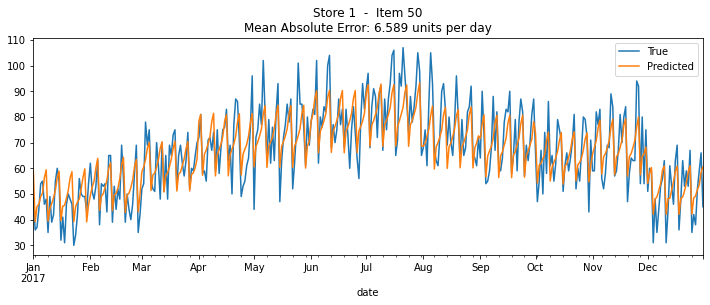

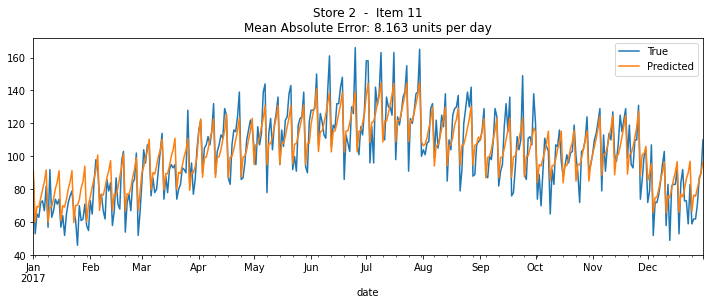

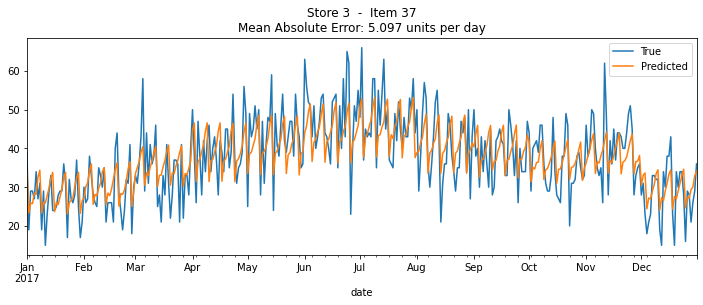

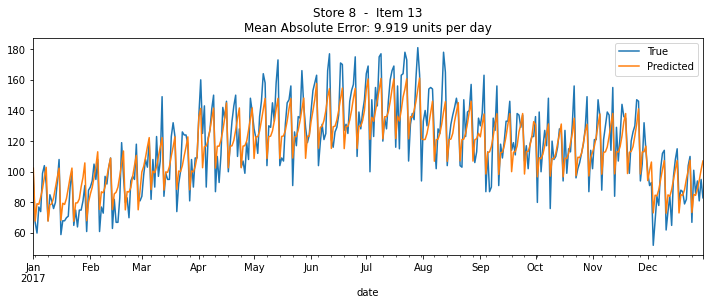

Overall MAE: 6.387934576055448
Overall PMAE: 0.13142008189309393


In [31]:
for store, item in [(1, 50), (2,11), (3,37), (8, 13)]:
    idx = (X_test['store'] == store) & (X_test['item']==item)

    error = (y_test[idx] - y_pred[idx]).abs().mean()
    plt.figure(figsize=(12,4))
    plt.title(f"Store {store}  -  Item {item}\nMean Absolute Error: {error:.3f} units per day")
    y_test[idx].plot(label="True")
    y_pred[idx].plot(label="Predicted")
    plt.legend()
    plt.show()

errors = (y_test-y_pred).abs().mean()
errors_pct = []
for store in range(1, 11):
    for item in range(1, 51):
        idx = (X_test['store'] == store) & (X_test['item']==item)
        errors_pct.append(((y_test[idx] - y_pred[idx]).abs()/y_test[idx]).mean())
        
errors_pct = pd.Series(errors_pct).mean()

print(f"Overall MAE: {errors}")
print(f"Overall PMAE: {errors_pct}")

Despite the increased complexity of the current model, not  an enormous improvement. Less than 1% better than our first attempt (0.13142 vs 0.13712, or half a percent). This is because we're already very close to the limits of what's possible with this data, and a good model can't improve things much more.

One interesting side effect of using this more powerful model is we can start to analyse which features are important for the model. I've plotted these below, and as expected, the various decomposition features we calculated earlier are the most important features. This is because most of the variance of our dataset is captured in those components, and the rest of our dataset allows the model to make mild adjustments. Interestingly, the "day of year" feature is highly important, suggesting there may be some nonlinear interactions between that variable and other factors that was not captured by our linear decompositions.

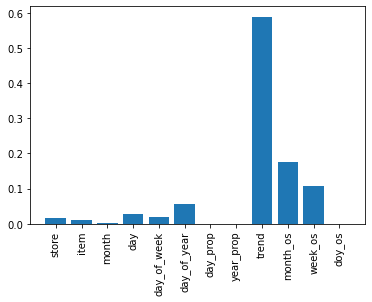

In [32]:
feature_importances = tabnet_feature_importances(learn.model.cpu(), dl)

plt.xticks(rotation='vertical')
plt.bar(dl.x_names, feature_importances)
plt.show()

So we seem to have a working model that is working about as well as it can, given the data we have. This dataset does have a number of advantages - it is incredibly regular from a collection standpoint, with full time series for all 10 stores, all 50 products over 5 years. There is no missing data, and the patterns seem to be fairly simple to model. However, it also lacks a lot of important information that may affect sales. Data such as store promotions, item discounts, or any reasonable pricing information, would all help to add a few more percent of accuracy to the overall system.

A dataset provided by a company would likely contain this information, but a company's dataset would also contain a number of challenges that did not affect this modelling process. The commencement or discontinuation of products would affect our ability to decompose our time series into such neat trend components (although deep learning could partially compensate for this). The difficulty in estimating how different store promotions interrelated would also cause issues. This is to say nothing of geographic effects (such as a local incoming storm) or global issues (as 2020 demonstrated).

As an observation, given how well this data behaves, and its surprising regularity, I suspect it may in fact be simulated.

Nevertheless, we will attempt to leverage slightly more information to solve our problem. Let's assume we don't need to forecast a year in advance. A number I've had suggested is 3 days in advance as plenty of time for a modern e-commerce business. Let's see if we can improve our initial estimate. Starting from a 3 day lag, we're going to do this by appending the following in a lazy manner:
- the sales of that item over the previous 14 days, individually
- the previous 2 weeks of that item, aggregated by week

In practice, we would regularly re-estimate the trends to make sure they're using the latest data too (perhaps once a week or so) but for the sake of this demo we're not going to bother.

In [71]:
day_offset=3
const = []
model_data = pd.concat([X, y], axis=1).sort_index()
for store in range(1, 11):
    for item in range(1, 51):
        
        temp = model_data.loc[(model_data.store==store)&(model_data.item==item)]
        shifts = [temp.sales.shift(day_offset+i).rename(f"shift_{i}")
                 for i in range(14)]
        rolling = temp.sales.rolling(7, min_periods=1).mean()
        const.append(pd.concat([
            temp] + shifts + [
            rolling.shift(day_offset+14).rename("rolling_1"),
            rolling.shift(day_offset+21).rename("rolling_2"),
                               ], axis=1))

model_data = pd.concat(const).dropna().sort_index()
X_train, X_test = model_data.drop('sales', axis=1).loc[:"2016-12-31"],\
        model_data.drop('sales', axis=1).loc["2017-01-01":]
y_train, y_test = model_data.sales.loc[:"2016-12-31"], model_data.sales.loc["2017-01-01":]

In [75]:
procs = [Categorify, FillMissing, Normalize]
cat_names = ['store', 'item', 'month', 'day', 'day_of_week', 'day_of_year']
cont_names = ['day_prop', 'year_prop', 'trend', 'month_os', 'week_os', 'doy_os'] + \
            [f"shift_{i}" for i in range(14)] + ['rolling_1', 'rolling_2']

dls = TabularDataLoaders.from_df(
    model_data,
    path=MPATH,
    cat_names = cat_names, cont_names=cont_names,
    y_names="sales",
    procs=procs,
    valid_idx=list(range(len(X_train),len(model_data))),
    bs=4096, 
)

In [76]:
emb_szs = get_emb_sz(dls)
model = TabNetModel(emb_szs, len(cont_names), dls.c, n_d=128, n_a=128, n_steps=8, mask_type='entmax')

learn = Learner(dls, model,
                loss_func=mae,
                metrics=[mae, rmse, msle, R2Score()],
                opt_func=ranger, wd=0.0001)

In [77]:
learn.fit_flat_cos(10,1e-1)

epoch,train_loss,valid_loss,mae,_rmse,msle,r2_score,time
0,7.804438,7.649043,7.649043,10.104909,0.037124,0.897436,00:49
1,7.033721,7.852479,7.852479,10.421907,0.036418,0.890900,00:58
2,6.622754,6.913668,6.913668,9.014116,0.031916,0.918384,01:08
3,6.331632,6.484159,6.484159,8.403087,0.028788,0.929074,01:10
4,6.076985,6.525016,6.525016,8.360527,0.030526,0.929790,01:08
5,5.908961,6.622093,6.622093,8.518552,0.030936,0.927111,01:07
6,5.938793,6.807578,6.807578,8.914236,0.029568,0.920183,01:01
7,5.812649,6.508190,6.508190,8.396634,0.028449,0.929183,00:52
8,5.761097,6.378627,6.378627,8.310490,0.026243,0.930628,00:54
9,5.685915,6.288098,6.288098,8.225126,0.025519,0.932046,00:54


In [78]:
dl = learn.dls.test_dl(X_test)
y_pred = pd.Series(learn.get_preds(dl=dl)[0].numpy().flatten(),
                   index=y_test.index)

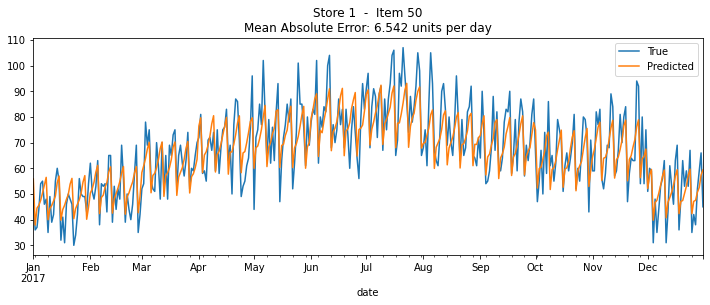

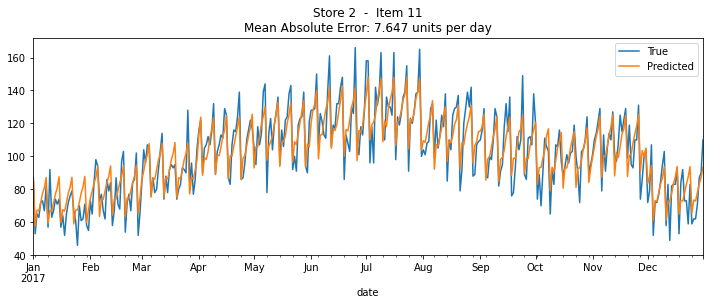

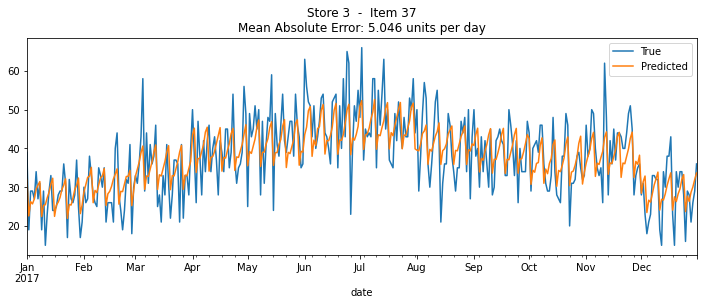

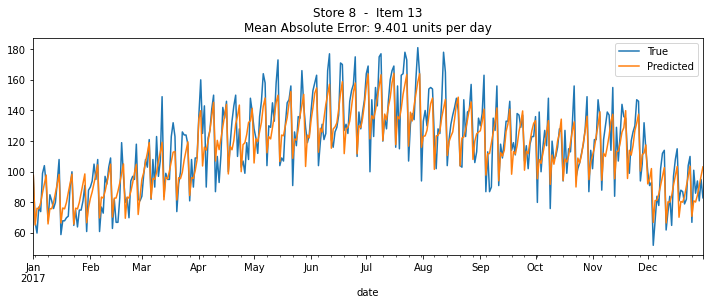

Overall MAE: 6.2880976793027905
Overall PMAE: 0.12910968814968307


In [79]:
for store, item in [(1, 50), (2,11), (3,37), (8, 13)]:
    idx = (X_test['store'] == store) & (X_test['item']==item)

    error = (y_test[idx] - y_pred[idx]).abs().mean()
    plt.figure(figsize=(12,4))
    plt.title(f"Store {store}  -  Item {item}\nMean Absolute Error: {error:.3f} units per day")
    y_test[idx].plot(label="True")
    y_pred[idx].plot(label="Predicted")
    plt.legend()
    plt.show()

errors = (y_test-y_pred).abs().mean()
errors_pct = []
for store in range(1, 11):
    for item in range(1, 51):
        idx = (X_test['store'] == store) & (X_test['item']==item)
        errors_pct.append(((y_test[idx] - y_pred[idx]).abs()/y_test[idx]).mean())
        
errors_pct = pd.Series(errors_pct).mean()

print(f"Overall MAE: {errors}")
print(f"Overall PMAE: {errors_pct}")

Another 0.2% improvement, but one that took very little effort to attain. With additional information, and study of the key areas where errors are made (e.g. Fridays? holidays?) it is possible that we could get this number under 10%, but this crucially depends on how variable demand for products is. (Also on the scale of the sales network.)

## Generalising to real scenarios

In practice we'd expect the results to be a little worse, as we've been a tad cavalier about using the validation set as our test set for the sake of demo, but I think most people will be familiar with how we would expect results to degrade in production.

We're going to quickly test a theory that we had earlier...that on the scale of weeks we're actually much more accurate than the daily estimates. This doesn't help for a just-in-time system, but it does help for e.g. maintaining a buffer of stocks.

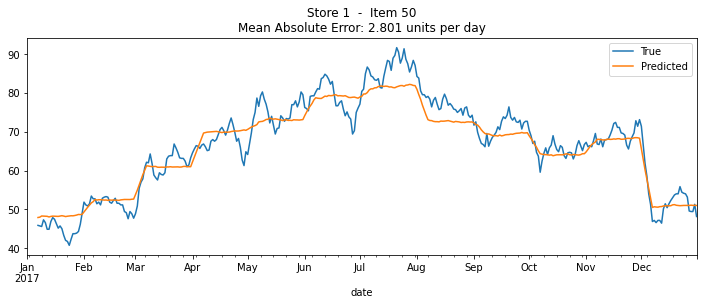

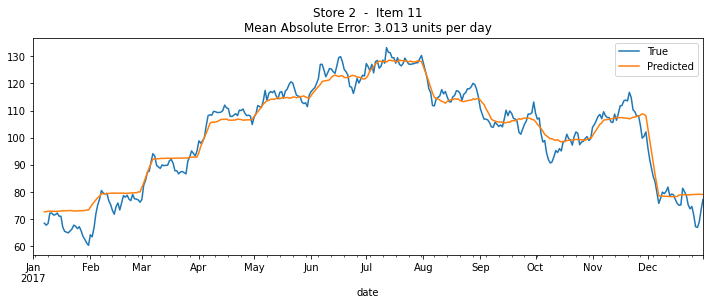

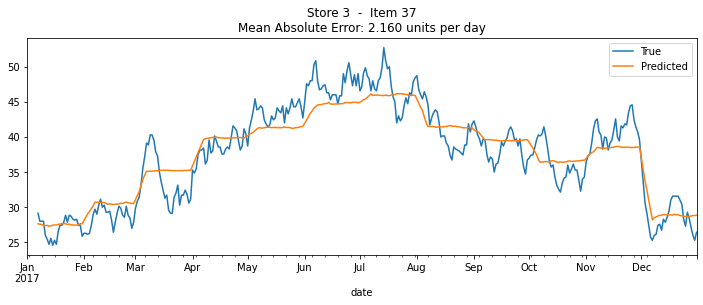

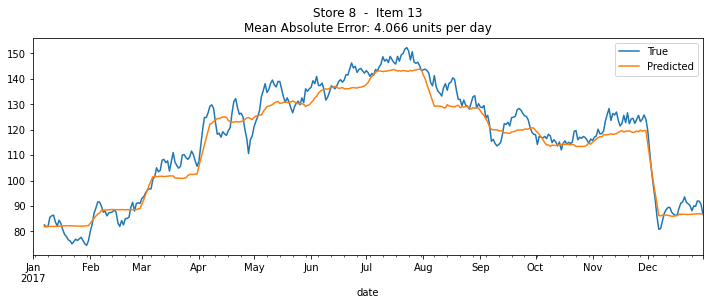

Overall MAE: 2.8205438054969383
Overall PMAE: 0.05262545568655948


In [82]:
for store, item in [(1, 50), (2,11), (3,37), (8, 13)]:
    idx = (X_test['store'] == store) & (X_test['item']==item)
    
    t1 = y_test[idx].rolling(7).mean()
    t2 = y_pred[idx].rolling(7).mean()
    error = (t1 - t2).abs().mean()
    plt.figure(figsize=(12,4))
    plt.title(f"Store {store}  -  Item {item}\nMean Absolute Error: {error:.3f} units per day")
    t1.plot(label="True")
    t2.plot(label="Predicted")
    plt.legend()
    plt.show()

errors = []
errors_pct = []
for store in range(1, 11):
    for item in range(1, 51):
        idx = (X_test['store'] == store) & (X_test['item']==item)
    
        t1 = y_test[idx].rolling(7).mean()
        t2 = y_pred[idx].rolling(7).mean()
        error = (t1 - t2).abs().mean()
        errors.append(error)
        errors_pct.append(error/t1.mean())

errors = pd.Series(errors).mean()
errors_pct = pd.Series(errors_pct).mean()

print(f"Overall MAE: {errors}")
print(f"Overall PMAE: {errors_pct}")

As predicted, we're now down around 5% error levels. Interestingly, from here we can see that the month decomposition is actually a significant driver of error (note the square shape in the predictions at month intervals). A smoothed version of it would almost certainly improve overall accuracy of the system. It was my expectation that our month-progress variable may have helped here, but I think what I'll need to do in practice is calculate a rolling window as perhaps this signal was too diffuse for the model to easily pick up.

But that is for future work.

Other areas where improvements could be made:
- Doing the initial decomposition of the year-long trends in the daily components
- Using state space models, or more complex models such as Gaussian processes, for the decomposition
- Smooth reestimation of the values through time, so the training dataset reflects an evolving training process
- Additional time series features, such as sales variability or skewness
- Automated model tuning
- Use of 1d convolultions to dynamically generate our rolling averages and local aggregations
- Domain knowledge integration to study the peaks of the system

For anyone reading this document, I hope this has given you some ideas about how to solve demand forecasting problems. This system can fairly simply be tweaked into specific operationally-actionable quantities with a bit of further knowledge of the demands of the business.